In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift, ifft2, ifftshift


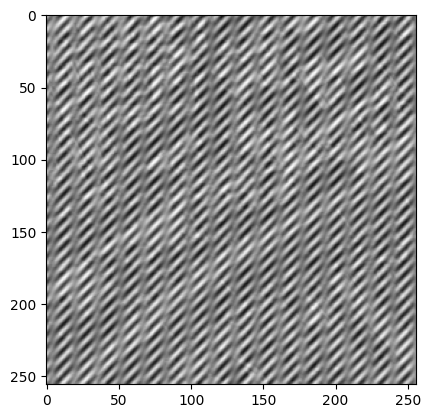

In [56]:
img1 = plt.imread("1.png")
plt.imshow(img1, cmap='gray')

In [57]:
img1.shape

(256, 256)

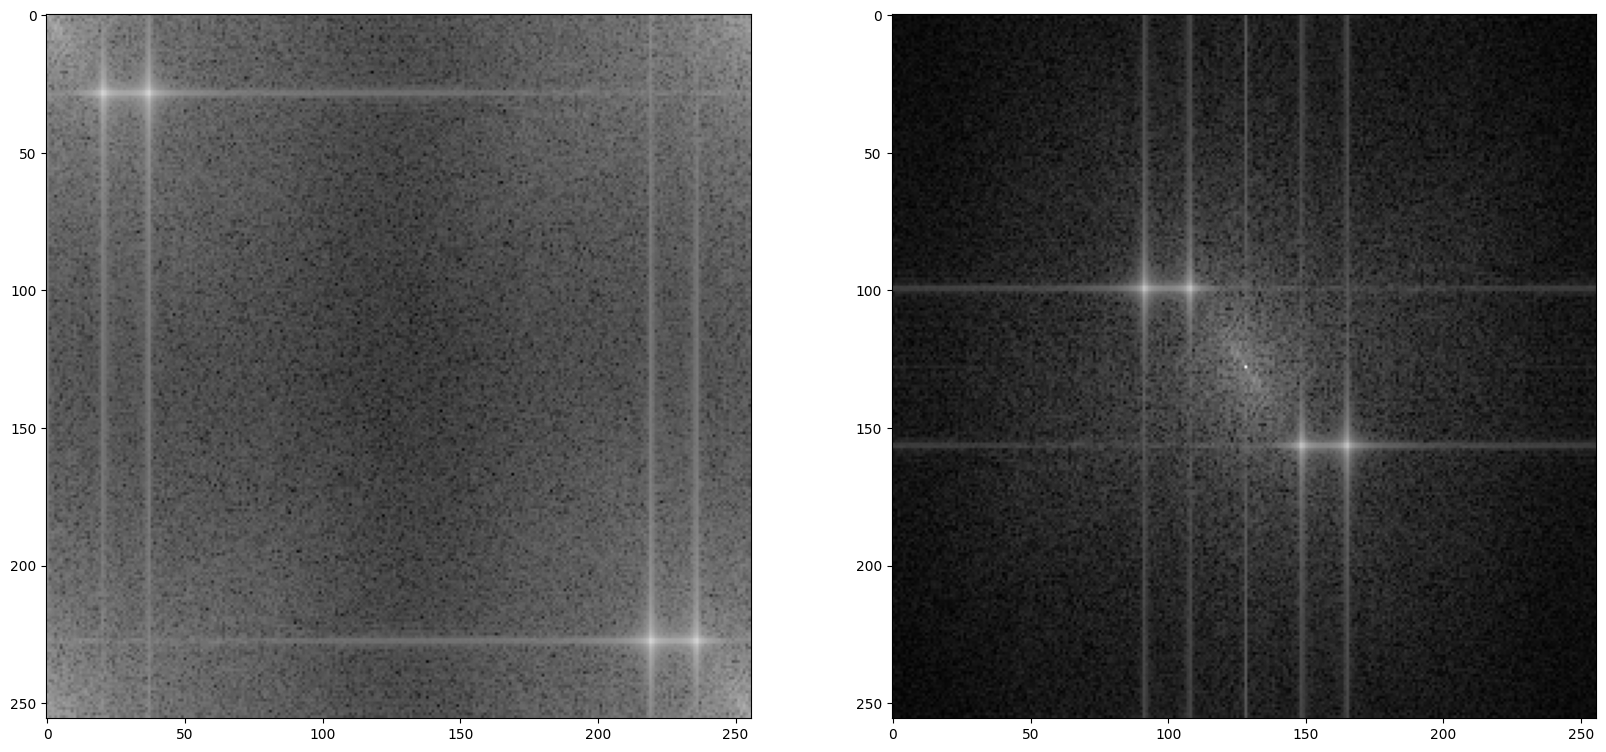

In [58]:
# Fourier transform
pad_img1 = np.zeros((img1.shape[0]*2, img1.shape[1]*2))
pad_img1[:img1.shape[0], :img1.shape[1]] = img1
F_img1 = fft2(img1)
F_shift_img1 = fftshift(F_img1)
#G_shift = F_shift * car_h_but_fn

# Inverse Fourier transform
#G = ifftshift(G_shift)
#g = ifft2(G)

plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.imshow(np.log(np.abs(F_img1)), cmap='gray')
#plt.axis('off')

plt.subplot(122)
plt.imshow(np.log(np.abs(F_shift_img1)+1), cmap='gray')
#plt.axis('off')

plt.show()

In [59]:
def clear_all(img, a, b, k=1):
    F = fft2(img)
    F_shift = fftshift(F)
    max_ = np.max((np.log(np.abs(F_shift))).ravel())
    std_ = np.std((np.log(np.abs(F_shift))).ravel())
    mean_ = np.median((np.log(np.abs(F_shift))).ravel())
    mean_f = np.median(F_shift)
    N, M = img.shape
    for i in range(N):
        for j in range(M):
            value = np.log(np.abs(F_shift[i,j]))
            if N//2-a < i < N//2+a and M//2-b < j < M//2+b:
                continue
            elif (mean_ + k*std_) < value < (max_):
                F_shift[i,j] = mean_f
    # Inverse Fourier transform
    G = ifftshift(F_shift)
    g =  ifft2(G)

    return g, F_shift

In [60]:
img1_clear_complex, G_img1 = clear_all(img1, a=20, b=15, k=1.8)
img1_clear = np.abs(img1_clear_complex)

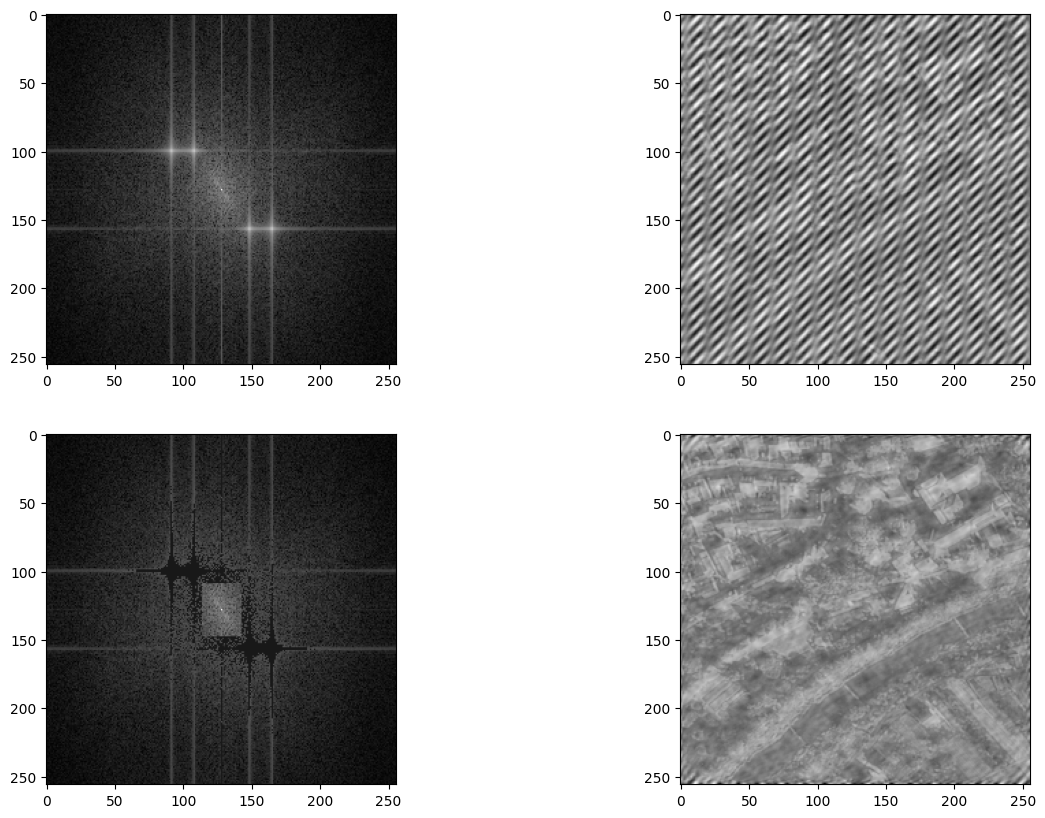

In [61]:
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.imshow(np.log(np.abs(F_shift_img1)+1), cmap='gray')
#plt.axis('off')
plt.subplot(222)
plt.imshow(img1, cmap='gray')
#plt.axis('off')


plt.subplot(223)
plt.imshow(np.log(np.abs(G_img1)+1), cmap='gray')

plt.subplot(224)
plt.imshow(img1_clear, cmap='gray')


In [62]:
img1_clear.min()

0.20687948

In [63]:
def butterworth_low_filter(img, D0, n, temp=-1, uk=0, vk=0):
    U, V = img.shape
    result = np.zeros((U, V))
    for u in range(U):
        for v in range(V):
            D = ( (u + temp*U/2 + uk)**2 + (v + temp*V/2 + vk)**2 )**0.5
            result[u, v] = 1 / (( 1 + (D/D0) )**(2*n))
    return result

/tmp/ipykernel_12974/4203410032.py:22: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(G_shift)), cmap='gray')


(-0.5, 255.5, 255.5, -0.5)

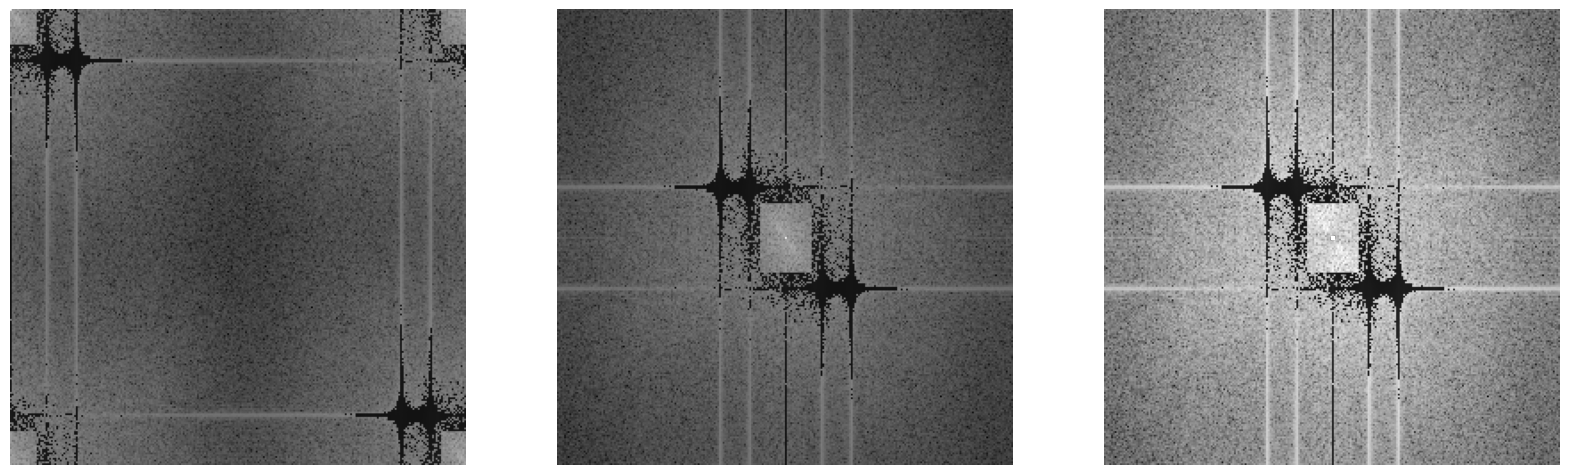

In [64]:
# Fourier transform
F = fft2(img1_clear)
F_shift = fftshift(F)
H_hight = 1 - butterworth_low_filter(img1_clear, 100, 2)
G_shift = F_shift * H_hight

# Inverse Fourier transform
G = ifftshift(G_shift)
g = ifft2(G).real

plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(np.log(np.abs(F)), cmap='gray')
plt.axis('off')

plt.subplot(132)
plt.imshow(np.log(np.abs(F_shift)), cmap='gray')
plt.axis('off')

plt.subplot(133)
plt.imshow(np.log(np.abs(G_shift)), cmap='gray')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

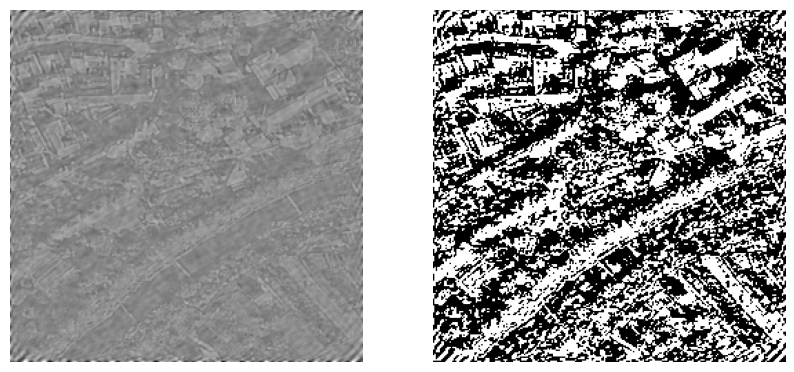

In [65]:
plt.figure(figsize=(10, 8))

plt.subplot(121)
plt.imshow(g, cmap='gray')
plt.axis('off')

g_thresh = g
for i in range(g.shape[0]):
    for j in range(g.shape[1]):
        if g_thresh[i, j] < 0:
            g_thresh[i, j] = 0
        else:
            g_thresh[i, j] = 1

plt.subplot(122)
plt.imshow(g_thresh, cmap='gray')
plt.axis('off')

In [66]:
def Mirror_Padding_v2(img, nx, ny):
    height, width = img.shape
    height_new = height + 2*nx
    width_new = width + 2*ny
    output = np.zeros([height_new, width_new])
    # Center
    output[nx:height_new-nx, ny:width_new-ny] = img
    # Top and Bottom
    output[:nx, ny:width_new-ny] = img[nx-1::-1, :] # Top
    output[height+nx:, ny:width_new-ny] = img[height-1:height-nx-1:-1, :] # Bottom
    # Left and Right
    output[:height_new, :ny] = output[:, 2*ny:ny:-1] # Left
    output[:height_new, width_new-ny:width_new] = output[:, width_new-ny-1:width_new-2*ny-1:-1] # Right
    return output

def GaussFunc(K, sigma, s, t):
    return K*np.exp(-0.5*(np.sqrt(s**2 + t**2))**2 / sigma**2)

def Gauss_Filter(img, size, K, sigma):
    # Create matrix Gauss
    x_axis = np.arange(size[0]//2+1)
    y_axis = np.arange(size[1]//2+1)
    matrix_gauss = np.zeros([size[0], size[1]])
    for y in range(0, size[0]):
        for x in range(0, size[1]):
            value = GaussFunc(K, sigma, x_axis[np.abs(size[0]//2-x)], y_axis[np.abs(size[1]//2-y)])
            matrix_gauss[x, y] = value
    print(matrix_gauss)
    matrix_gauss = 1/np.sum(matrix_gauss) * matrix_gauss
    # Create matrix Gauss
    img = Mirror_Padding_v2(img, size[0], size[1])
    m, n = img.shape
    output = np.zeros([m ,n])
    if size[0] % 2 == 0: c1 = 0
    else: c1 = 1
    if size[1] % 2 == 0: c2 = 0
    else: c2 = 1
    for x in range(size[0], m-size[0]):
        for y in range(size[1], n-size[1]):
            elements = img[x-size[0]//2:x+size[0]//2+c1, y-size[1]//2:y+size[1]//2+c2]
            fxy = elements*matrix_gauss
            output[x,y] = np.sum(fxy)
    return output[size[0]:m-size[0], size[1]:n-size[1]]

def Increase_Edge(img, K, size=(5,5), K_gaus=1, sigma=1):
    img_smooth = Gauss_Filter(img, size, K_gaus, sigma)
    gmask = img - img_smooth
    return img + K*gmask

[[0.36787944 0.60653066 0.36787944]
 [0.60653066 1.         0.60653066]
 [0.36787944 0.60653066 0.36787944]]


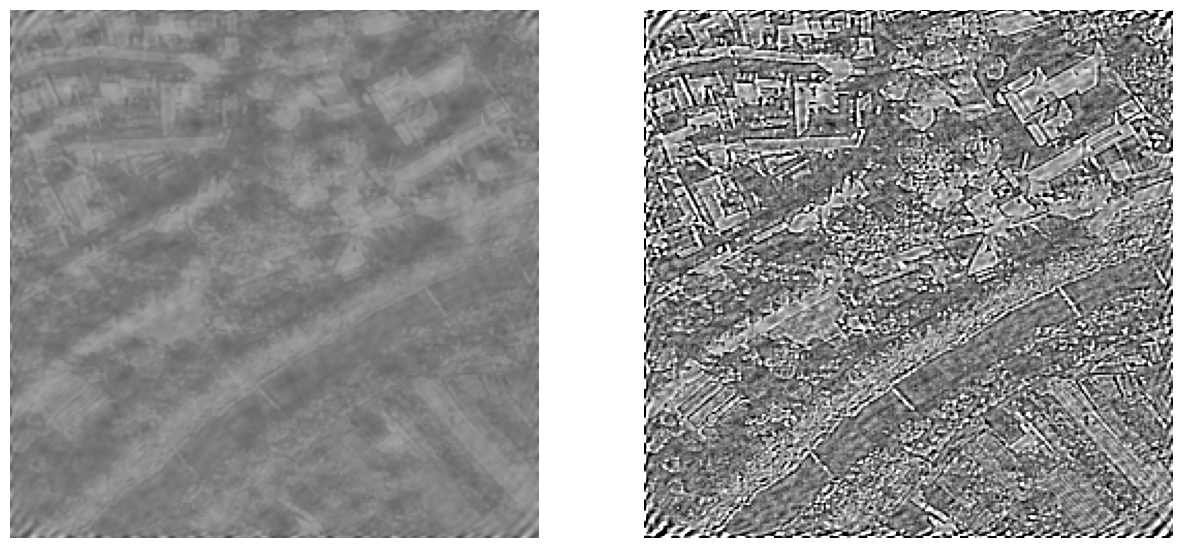

In [67]:
img1_clear_in = Increase_Edge(img1_clear, K=20, size=(3, 3), K_gaus=1, sigma=1)


plt.figure(figsize=(15, 10))

plt.subplot(121)
plt.imshow(img1_clear, cmap="gray", vmin=0, vmax=1)
plt.axis('off')

plt.subplot(122)
plt.imshow(img1_clear_in, cmap='gray', vmin=0, vmax=1)
plt.axis('off')

plt.show()

In [68]:
img1_clear.min()

0.20687948

In [69]:
img1_clear_in.min()

-2.583463397339373

In [70]:

def Laplace_Filter(img, H, return_Laplace=False, k=1):
    # Get Constant metrices
    Hn = np.array([[[0,1,0], [1,-4,1], [0,1,0]],
                 [[1,1,1], [1,-8,1], [1,1,1]],
                 [[0,-1,0], [-1,4,-1], [0,-1,0]],
                 [[-1,-1,-1], [-1,8,-1], [-1,-1,-1]]])
    cn = [-1, -1, 1, 1]
    H = H-1
    # Get Constant
    img = Mirror_Padding_v2(img, 3, 3)
    m, n = img.shape
    output = np.zeros([m, n])
    for x in range(3, m-3):
        for y in range(3, n-3):
            elements = img[x-3//2:x+3//2+1, y-3//2:y+3//2+1]
            value = np.multiply(cn[H]*Hn[H], elements)
            if return_Laplace == True:
                output = np.sum(value)
            else:
                output[x,y] = img[x, y] + k*np.sum(value)
    return output[3:m-3, 3:n-3]
    
def Sobal_Filter(img, return_abs=False):
    # Get Constant metrices
    wx = np.array([[-1.0,-2.0,-1.0], [0.0,0.0,0.0], [1.0,2.0,1.0]])
    wy = np.array([[-1.0,0.0,1.0], [-2.0,0.0,2.0], [-1.0,0.0,1.0]])
    # Get Constant metrices
    img = Mirror_Padding_v2(img, 3, 3)
    m, n = img.shape
    output = np.zeros([m, n])
    for x in range(3, m-3):
        for y in range(3, n-3):
            elements = img[x-3//2:x+3//2+1, y-3//2:y+3//2+1]
            gx = np.sum(np.multiply(wx, elements))
            gy = np.sum(np.multiply(wy, elements))
            if return_abs == True:
                output[x, y] = np.abs(gx) + np.abs(gy)
            else:    
                output[x, y] = np.sqrt(gx**2 + gy**2)
    return output[3:m-3, 3:n-3]


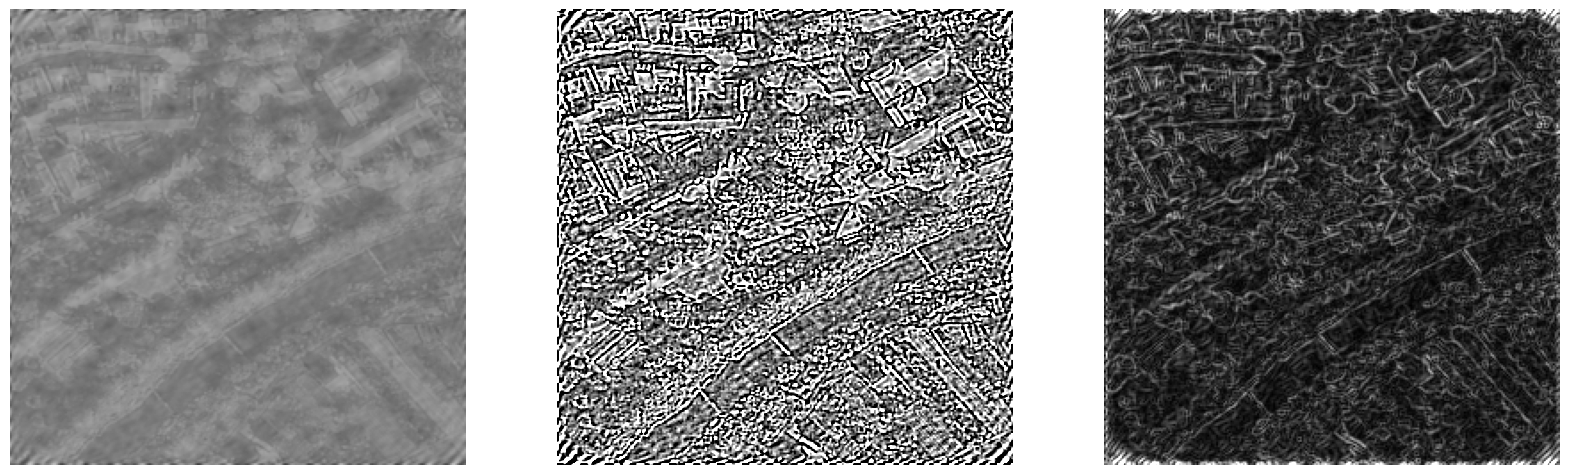

In [71]:
img1_laplace = Laplace_Filter(img1_clear, H=4, k=5)
img1_sobel = Sobal_Filter(img1_clear, return_abs=True)

plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(img1_clear, cmap="gray", vmin=0, vmax=1)
plt.axis('off')

plt.subplot(132)
plt.imshow(img1_laplace, cmap='gray', vmin=0, vmax=1)
plt.axis('off')

plt.subplot(133)
plt.imshow(img1_sobel, cmap='gray', vmin=0, vmax=1)
plt.axis('off')

plt.show()

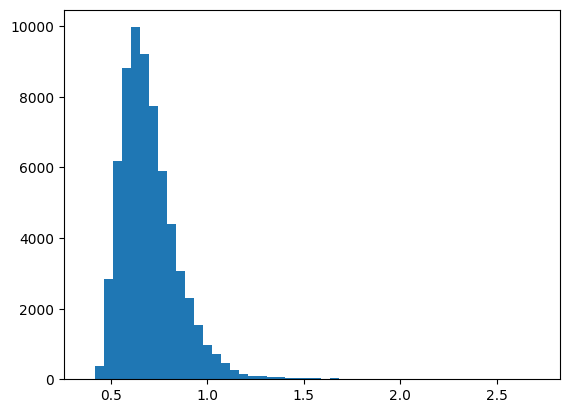

In [72]:
img1_clear_v2 = (img1_clear + 1*img1_sobel)
plt.hist(img1_clear_v2.ravel(), bins=50)
plt.show()

Text(0.5, 1.0, 'Anh goc')

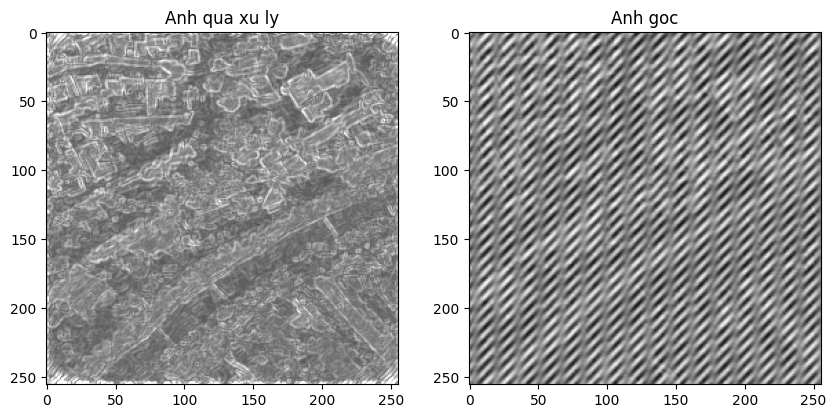

In [73]:
plt.figure(figsize=(10, 8))

plt.subplot(121)
plt.imshow(img1_clear_v2, cmap='gray', vmin=0., vmax=1.3)
plt.title("Anh qua xu ly")

plt.subplot(122)
plt.imshow(img1, cmap='gray')
plt.title("Anh goc")


# Cau 2

In [74]:
img2 = plt.imread("2.jpg")
img2.shape

(2047, 1680, 3)

In [75]:
def Grayscale_Average(img):
    R = np.array(img[:,:,0], dtype=np.float32)
    G = np.array(img[:,:,1], dtype=np.float32)
    B = np.array(img[:,:,2], dtype=np.float32)
    output = (R + G + B) / 3
    return output

In [76]:
img2 = Grayscale_Average(img2)
img2.shape

(2047, 1680)

In [77]:
img2_sobel = Sobal_Filter(img2, return_abs=True)

In [78]:
def gamma(c, factor, img):
    return c*img**factor

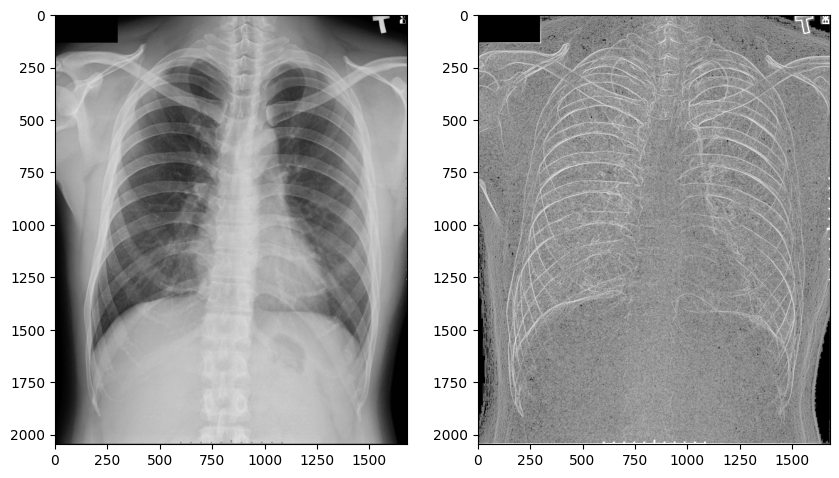

In [79]:
img2_sobel_gamma = gamma(1, 0.2, img2_sobel)
plt.figure(figsize=(10, 8))

plt.subplot(121)
plt.imshow(img2, cmap='gray')

plt.subplot(122)
plt.imshow(img2_sobel_gamma, cmap='gray',vmin=0, vmax=3)

In [80]:
img3 = plt.imread("2023.jpeg")
img3 = Grayscale_Average(img3)
img3_sobel = gamma(1, 2, img3)

/tmp/ipykernel_12974/3505563664.py:2: RuntimeWarning: overflow encountered in power
  return c*img**factor


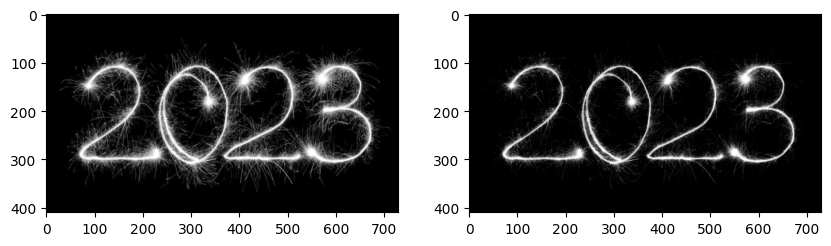

In [81]:
img3_sobel_gamma = gamma(1, 300, img3_sobel)
plt.figure(figsize=(10, 8))

plt.subplot(121)
plt.imshow(img3, cmap='gray')

plt.subplot(122)
plt.imshow(img3_sobel, cmap='gray')